In [1]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00


In [1]:
!pip install evaluate
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

amazon_dataset = load_dataset('amazon_reviews_multi')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset_en = []
for el in amazon_dataset['train']:
    if el['language'] == 'en':
        el.pop("review_id")
        el.pop("product_id")
        el.pop("reviewer_id")
        el.pop("review_title")
        el.pop("language")
        el.pop("product_category")
        el["text"] = el.pop("review_body")
        el["label"] = el.pop("stars")
        el["label"] = el["label"] - 1
        dataset_en.append(el)

In [4]:
dataset_en_val = []
for el in amazon_dataset['validation']:
    if el['language'] == 'en':
        el.pop("review_id")
        el.pop("product_id")
        el.pop("reviewer_id")
        el.pop("review_title")
        el.pop("language")
        el.pop("product_category")
        el["text"] = el.pop("review_body")
        el["label"] = el.pop("stars")
        el["label"] = el["label"] - 1
        dataset_en_val.append(el)

In [5]:
from datasets import Dataset
import pandas as pd

df = pd.DataFrame(dataset_en)

In [6]:
df_val = pd.DataFrame(dataset_en_val)

In [7]:
dataset_amazon = Dataset.from_dict(df)

In [8]:
dataset_amazon_val = Dataset.from_dict(df_val)

In [9]:
from transformers import AutoTokenizer

tokenizer_xlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')

In [11]:
def tokenize_function_xlnet(examples):
    return tokenizer_xlnet(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets_xlnet = dataset_amazon.map(tokenize_function_xlnet, batched=True)

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

In [12]:
tokenized_datasets_xlnet_val = dataset_amazon_val.map(tokenize_function_xlnet, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [13]:
small_train_dataset_xlnet = tokenized_datasets_xlnet.shuffle(seed=42).select(range(1000))
small_eval_dataset_xlnet = tokenized_datasets_xlnet_val.shuffle(seed=42).select(range(1000))

In [14]:
from transformers import AutoModelForSequenceClassification

model_xlnet = AutoModelForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=5)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [15]:
from transformers import TrainingArguments, Trainer

training_args_xlnet = TrainingArguments(output_dir="test_trainer_xlnet", evaluation_strategy="epoch", num_train_epochs=4,
                                      per_device_train_batch_size=8, per_device_eval_batch_size=8)

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [18]:
trainer_xlnet = Trainer(
    model=model_xlnet,
    args=training_args_xlnet,
    train_dataset=small_train_dataset_xlnet,
    eval_dataset=small_eval_dataset_xlnet,
    compute_metrics=compute_metrics,
)

In [19]:
trainer_xlnet.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.292777,0.452000
2,No log,1.146919,0.511000
3,No log,1.439580,0.507000
4,0.898900,1.643538,0.529000


TrainOutput(global_step=500, training_loss=0.8989132690429688, metrics={'train_runtime': 1263.3593, 'train_samples_per_second': 3.166, 'train_steps_per_second': 0.396, 'total_flos': 1139549466624000.0, 'train_loss': 0.8989132690429688, 'epoch': 4.0})

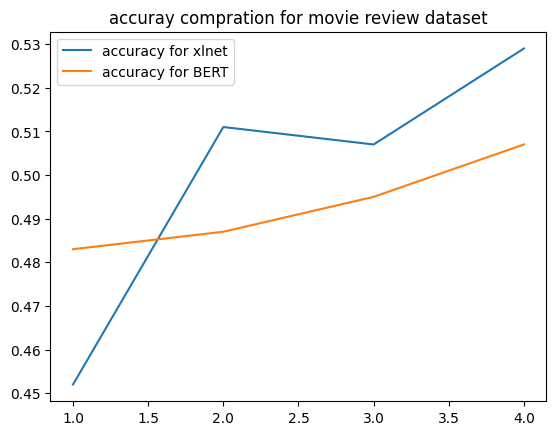

In [20]:
import matplotlib.pyplot as plt

x = range(1, 5)
y_xlnet = [0.452000, 0.511000, 0.507000, 0.529000]
y_bert = [0.483000, 0.487000, 0.495000, 0.507000]
plt.plot(x, y_xlnet, label='accuracy for xlnet')
plt.plot(x, y_bert, label='accuracy for BERT')
plt.title('accuray compration for movie review dataset')
plt.legend()
plt.show()

In [22]:
amazon_dataset['train'][50000]

{'review_id': 'de_0879234',
 'product_id': 'product_de_0158995',
 'reviewer_id': 'reviewer_de_0270811',
 'stars': 2,
 'review_body': 'Von der Optik ganz gut, aber schlechte Verarbeitung, leider lockern sich die Schrauben schnell und fassen nicht mehr, da sie sehr kurz sind und es nur pressspahn ist. Die Beschichtung wird schnell fleckig.',
 'review_title': 'Nicht so toll',
 'language': 'de',
 'product_category': 'home_improvement'}

In [25]:
for i, val in enumerate(amazon_dataset['train']):
    if val['language'] == 'en':
        print(i, val)
        break

200000 {'review_id': 'en_0964290', 'product_id': 'product_en_0740675', 'reviewer_id': 'reviewer_en_0342986', 'stars': 1, 'review_body': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.", 'review_title': "I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...", 'language': 'en', 'product_category': 'furniture'}


In [26]:
amazon_dataset['train'][200000]

{'review_id': 'en_0964290',
 'product_id': 'product_en_0740675',
 'reviewer_id': 'reviewer_en_0342986',
 'stars': 1,
 'review_body': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
 'review_title': "I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...",
 'language': 'en',
 'product_category': 'furniture'}